<a   href="https://colab.research.google.com/github/N-Nieto/OHBM_SEA-SIG_Educational_Course/blob/master/03_pitfalls/03_03_imbalance_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalance learning: Metrics

### Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
)

from imblearn.metrics import sensitivity_specificity_support

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore


### Data loading and preparation

In [17]:
# Prepare the data
# Features: Cortical + Subcortical
features = ["cortical", "subcortical"]

# Target: Height
target = ["SEX_ID (1=m, 2=f)"]
# Confounding variables: Sex, Age
confounding = ["SEX_ID (1=m, 2=f)", "AGE"]
confounding = []


df_data = pd.read_csv("cleaned_IXI_behavioural.csv", index_col=0)
columns_features = []
for feature in features:
    if feature == "cortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv", index_col=0
        )
    elif feature == "subcortical":
        df_feature = pd.read_csv(
            "cleaned_VBM_GM_TianxS1x3TxMNI6thgeneration_mean_aggregation.csv",
            index_col=0,
        )
    else:
        print("feature not recognized")

    df_data = df_data.join(df_feature, how="inner")
    columns_features = columns_features + df_feature.columns.to_list()


print(f"Initial data shape: {df_data.shape}")

# Check for NaNs in confounding columns
confounding_cols = target + confounding
for col in confounding_cols:
    if df_data[col].isna().sum() > 0:
        print(f"{df_data[col].isna().sum()} NaNs in column {col}.")
        print("Drop NaNs and align subjects")

        # Drop NaNs from the brain dataframe (which contains all columns)
        df_data = df_data.dropna(subset=[col])
        print(f"New data shape: {df_data.shape}")
    else:
        print(f"No NaNs in column {col}.")

print(f"Final data shape: {df_data.shape}")

y = df_data[target].values.ravel()
if target == ["SEX_ID (1=m, 2=f)"]:
    y = np.where(y == 2, 0, 1)  # 1


X = df_data.loc[:, columns_features].values  # only brain features

print("X shape")
print(X.shape)


Initial data shape: (591, 122)
No NaNs in column SEX_ID (1=m, 2=f).
Final data shape: (591, 122)
X shape
(591, 116)


### Forcing Imbalance

In [18]:
# Force imbalance in the dataset
imbalance_ratio = 0.15  # Minority class will be 10% of majority class
X_minority = X[y == 0]
y_minority = y[y == 0]
X_majority = X[y == 1][: int(imbalance_ratio * len(X_minority))]
y_majority = y[y == 1][
    : int(imbalance_ratio * len(X_minority))
]  # Keep only 10% of majority class
X = np.vstack((X_minority, X_majority))
y = np.hstack((y_minority, y_majority))

print("X shape")
print(X.shape)
print("Target distribution")
print(y.sum(), len(y) - y.sum())
print(f"Imbalance ratio: {y.sum()/len(y):.2f}")

X shape
(377, 116)
Target distribution
49 328
Imbalance ratio: 0.13


## Training a ML model and plot performance

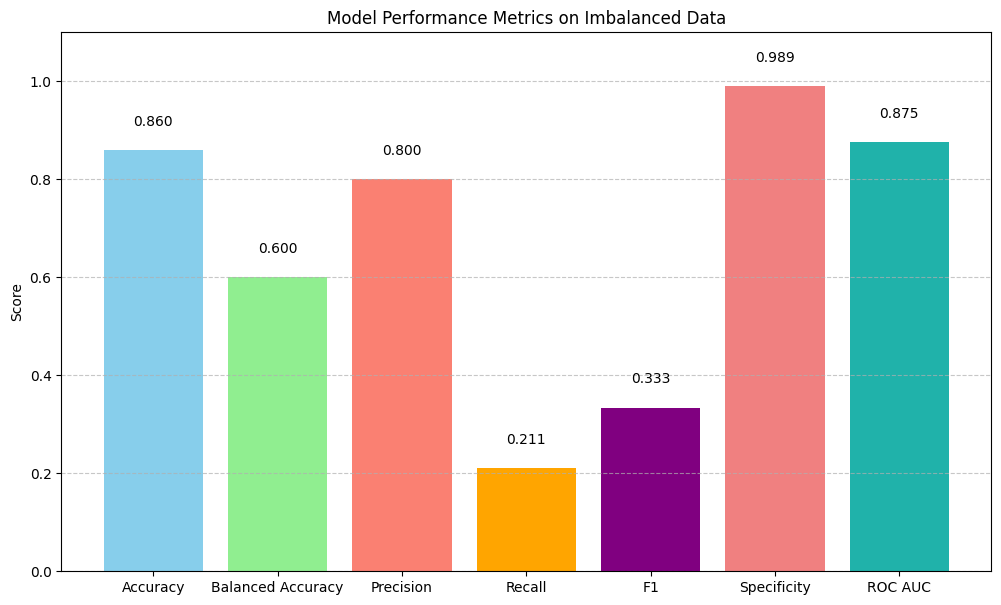

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Specificity": sensitivity_specificity_support(y_test, y_pred)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba),
}


# Plot metrics
plt.figure(figsize=(12, 7))
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.bar(
    metrics.keys(),
    metrics.values(),
    color=[
        "skyblue",
        "lightgreen",
        "salmon",
        "orange",
        "purple",
        "lightcoral",
        "lightseagreen",
    ],
)
plt.title("Model Performance Metrics on Imbalanced Data")
plt.ylim(0, 1.1)

plt.ylabel("Score")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.05, f"{v:.3f}", ha="center")
plt.show()


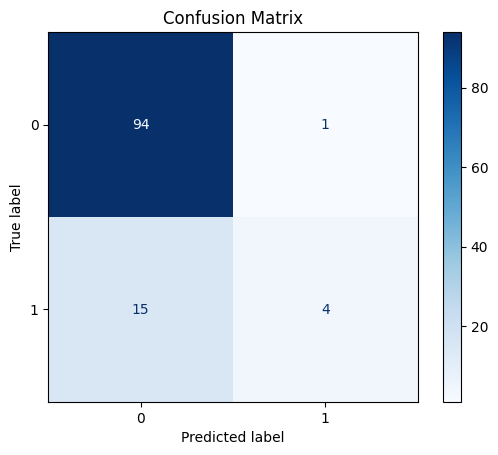

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Methods

In [21]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Using class weighting
model_weighted = LogisticRegression(max_iter=1000, class_weight="balanced")
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)

# Calculate metrics with class weighting
metrics_weighted = {
    "Accuracy": accuracy_score(y_test, y_pred_weighted),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_weighted),
    "Recall": recall_score(y_test, y_pred_weighted),
    "F1": f1_score(y_test, y_pred_weighted),
    "Specificity": sensitivity_specificity_support(y_test, y_pred_weighted)[0][0],
    "ROC AUC": roc_auc_score(y_test, model_weighted.predict_proba(X_test)[:, 1]),


}


# Train BalancedRandomForest on original imbalanced data
brf = BalancedRandomForestClassifier(n_estimators=10, random_state=42)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
y_proba_brf = brf.predict_proba(X_test)[:, 1]

# Calculate metrics for BalancedRandomForest
metrics_brf = {
    "Accuracy": accuracy_score(y_test, y_pred_brf),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred_brf),
    "Recall": recall_score(y_test, y_pred_brf),
    "F1": f1_score(y_test, y_pred_brf),
    "Specificity": sensitivity_specificity_support(y_test, y_pred_brf)[0][0],
    "ROC AUC": roc_auc_score(y_test, y_proba_brf),
}


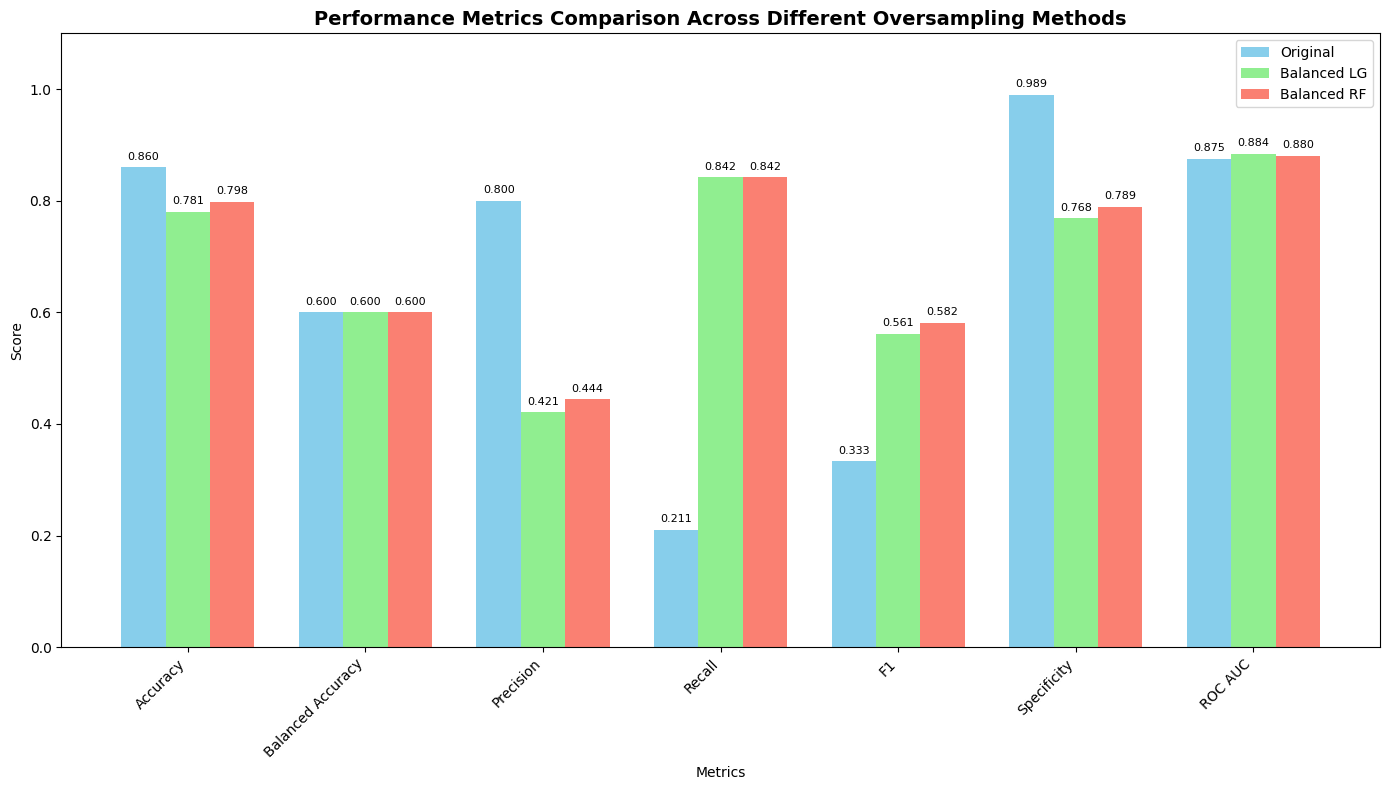

In [22]:
# Create comparison dataframe
comparison_df = pd.DataFrame(
    {"Original": metrics, "Balanced LG": metrics_weighted, "Balanced RF": metrics_brf}
)

# Plot comparison - one metric per subplot
metrics_list = list(metrics.keys())
n_metrics = len(metrics_list)

# Alternative: Single plot with all metrics grouped by method
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics_list))
width = 0.25

bars1 = ax.bar(
    x - width,
    [metrics[m] for m in metrics_list],
    width,
    label="Original",
    color="skyblue",
)
bars2 = ax.bar(
    x,
    [metrics_weighted[m] for m in metrics_list],
    width,
    label="Balanced LG",
    color="lightgreen",
)
bars3 = ax.bar(
    x + width,
    [metrics_brf[m] for m in metrics_list],
    width,
    label="Balanced RF",
    color="salmon",
)

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title(
    "Performance Metrics Comparison Across Different Oversampling Methods",
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(metrics_list, rotation=45, ha="right")
ax.legend()
ax.set_ylim(0, 1.1)


# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )


add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.show()

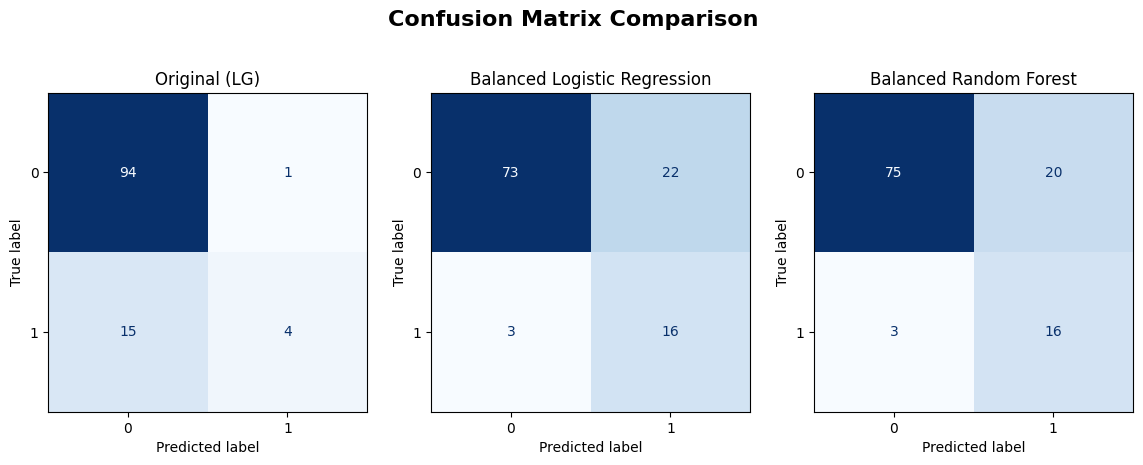

In [23]:
# Confusion matrix comparison
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0], cmap="Blues")
ax[0].set_title("Original (LG)")
ConfusionMatrixDisplay.from_estimator(model_weighted, X_test, y_test, ax=ax[1], cmap="Blues")
ax[1].set_title("Balanced Logistic Regression")
ConfusionMatrixDisplay.from_estimator(
    brf, X_test, y_test, ax=ax[2], cmap="Blues"
)
ax[2].set_title("Balanced Random Forest")
ax[0].figure.suptitle("Confusion Matrix Comparison", fontsize=16, fontweight="bold")
# Remove the color bar from all confusion matrix plots
for axes in ax:
    if hasattr(axes, "images") and axes.images:
        for im in axes.images:
            if im.colorbar:
                im.colorbar.remove()

plt.show()
